In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from random import randint

In [2]:
from sklearn.calibration import LabelEncoder
from common import get_full_data
def heart_failure():
    df = pd.read_csv("dataset/heart_failure_clinical_records_dataset.csv")
    # get dependent and independent features
    X=df.iloc[:,:-1]
    y=df.iloc[:,-1]
    classes = y.unique()
    X,y=get_full_data(X,y)
    return X,y,[str(c) for c in classes]

def encode_categorical_columns(df):
    le = LabelEncoder()
    # Loop over all columns in the DataFrame
    for col in df.columns:
        # Check if the column is of type object (string)
        if df[col].dtype == 'object':
            # Use LabelEncoder to do the numeric transformation
            df[col] = le.fit_transform(df[col])
    return df

def disease():
    df = pd.read_csv("dataset/disease.csv")
    # get dependent and independent features
    classes = df.iloc[:,0].unique()
    df = encode_categorical_columns(df)

    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    return X,y, classes

def seeds():
    df = pd.read_csv("dataset/seeds.csv")
    y = df.iloc[:,-1]-1
    classes = y.apply(lambda x: str(x)).unique()
    X = df.iloc[:,:-1]
    return X,y, classes


In [3]:
from xgboost import XGBRegressor,  XGBClassifier
X,y, y_classes = seeds()

# for high-dimensional data use `gpu` for device if you have one
special_model = XGBClassifier(device='cpu')

In [4]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from common import XGB_search_params

params = XGB_search_params()
state = randint(0,1000)
search = RandomizedSearchCV(
    special_model,
    params,
    n_iter=200,
    cv=5,
    random_state=state,
    n_jobs=-1,
)

search.fit(X,y)
special_model=search.best_estimator_

In [5]:
# do repeated stratified k-fold cross-validation with classification report
from sklearn.model_selection import RepeatedStratifiedKFold
from common import cross_val_classification_report

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=50)
report = cross_val_classification_report(
    model=special_model,
    X=X.to_numpy(),
    y=y,
    cv=cv,
    target_names=y_classes
)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       198
           1       0.92      0.94      0.93       204
           2       0.89      0.93      0.91       195

    accuracy                           0.89       597
   macro avg       0.89      0.89      0.89       597
weighted avg       0.89      0.89      0.89       597



Evaluate score  0.0778723432817402


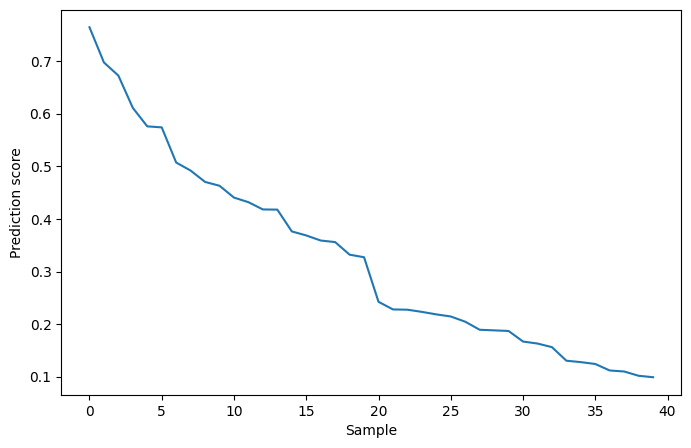

Evaluate score  0.05692011894007463


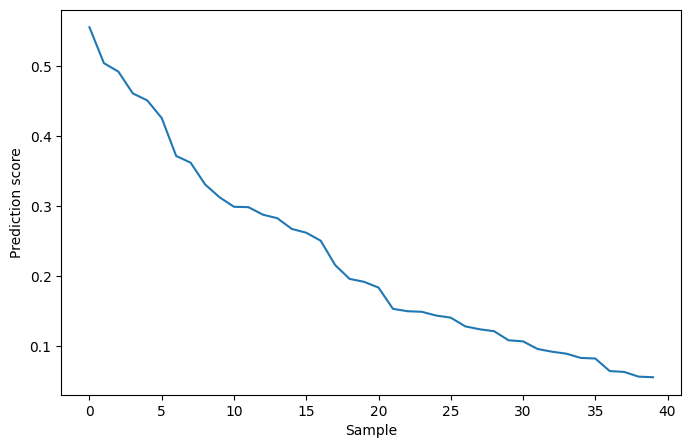

Evaluate score  0.0505234242843994


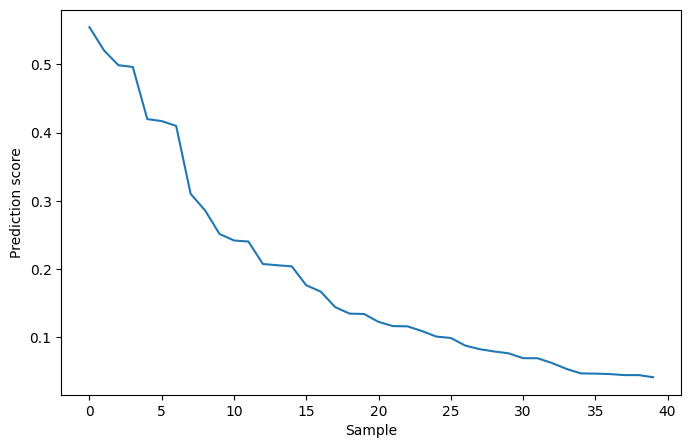

Evaluate score  0.04779784849259141


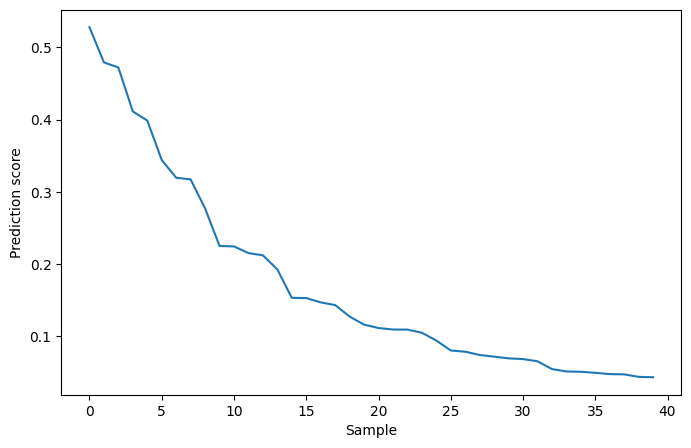

Evaluate score  0.04458727991108707


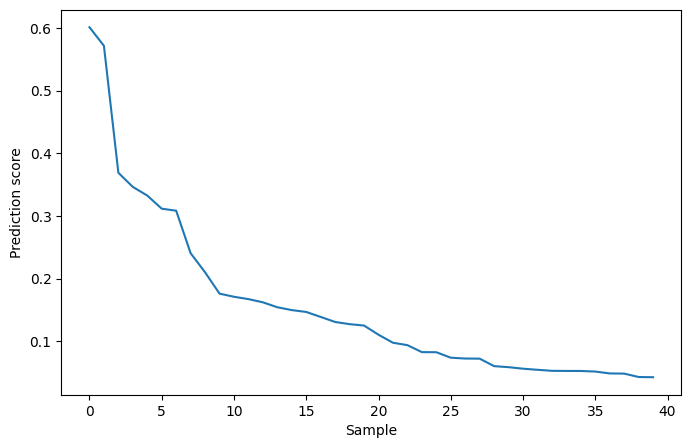

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       156
           1       0.99      1.00      0.99       201
           2       0.97      0.98      0.98       183

    accuracy                           0.98       540
   macro avg       0.98      0.97      0.97       540
weighted avg       0.98      0.98      0.98       540



In [6]:
# New method
from common import find_outliers

X_numpy = X.to_numpy()
y_numpy = y.to_numpy()

outliers_mask, score = find_outliers(
    X_numpy,
    y_numpy,
    special_model,
    outliers_to_remove=0.1,
    iterations=5,
    gamma=0.5,
    evaluate_loss=metrics.mean_squared_error,
    repeats=5,
    cv=10,
    plot=True
)

X_clean = X_numpy[~outliers_mask]
y_clean = y_numpy[~outliers_mask]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=50)
report = cross_val_classification_report(
    model=special_model,
    X=X_clean,
    y=y_clean,
    cv=cv,
    target_names=y_classes
)
print(report)


Compare performance with some control model `SVC` with `rbf` kernel and standard scaler

Find optimal hyperparameters using `RandomSearchCV`

In [8]:
from common import optimalKernelPCA,generate_colors_for_classification
from render import plot_3d_rgb

kpca_results = optimalKernelPCA(X,n_components=3)
colors = generate_colors_for_classification(y,seed=100)
x_transform = kpca_results.X_transform
data = np.concatenate([x_transform,colors],axis=1)
plot_3d_rgb(data,"Original data plot",["d1","d2","d3"])

x_clean_scaled = kpca_results.data_scaler.transform(X_clean)
x_clean_transform = kpca_results.kpca.transform(x_clean_scaled)
y_clean_colors = generate_colors_for_classification(y_clean,seed=100)
data_clean = np.concatenate([x_clean_transform,y_clean_colors],axis=1)
plot_3d_rgb(data_clean,"Cleaned data plot",["d1","d2","d3"])



/home/vlad/Programs/Git/python-outliers-detector/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning:


95 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vlad/Programs/Git/python-outliers-detector/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/home/vlad/Programs/Git/python-outliers-detector/venv/lib/python3.11/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File

/home/vlad/Programs/Git/python-outliers-detector/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

